# Sandwich shop
We want to investigate if adding an extra crew member during rush hour is worth our trouble.

#### Some relevant information:
* The arrival time between clients $\left(T\right)$ is a stochastic variable following an exponential distribution with parameter $\lambda(t)$, where $\lambda$ also depends on the time of day. From historical data we know the following about the mean time between client arrivals:
    * from 00:00 until 08:00: shop is closed
    * from 08:00 until 11:00: 25 minutes
    * from 11:00 until 14:00: 1 minutes
    * from 14:00 until 17:00: 10 minutes
    * from 17:00 until 19:00: 2 minutes
    * from 19:00 until 20:00: 5 minutes
    * from 20:00 until 24:00: shop is closed
    
    **Remark: in reality you would execute a measurements campaign and verify if the experimental distribution actually follows an exponential distribution (by means of a Kolmogorov–Smirnov test)**
        
* If an employee is available the client places an order (we could also incorporate a decision time). This implies that we need the shop to have a limited `::Resource` i.e. the employees. 

    If no one is available, the client waits for his turn, but has a limited amount of patience. When this runs out, the clients leaves the shop (and should cancel his request for the employee `Resource`). Patience for the different clients is defined as a random variable $\sim\mathcal{U}(5,10)$. 
    * `Resource.level` is the current amount of resources in use
    * `Resource.capacity` is the total amount of resources
    * `Resource.put_queue` are the scheduled processes for the resource and can be used for queue length
* Once the order is placed, the preperation time is also a random variable (possibly depending on the type of sandwich).

#### Topics:

1. We need to log the activities in our shop:
    1. Queue build-up $\rightarrow$ logging of queue required
    2. Waiting times $\rightarrow$ logging of waiting times required

#### Some food for thought:
* What if we considered clients with a memory? I.e. if they do not get served within their patience range, they go away and spread they word (which in its turn influences future arrival rates).
* Is the extra person worth it from an economic point of view?
* Could you also include orders that are place by phone before a specific time (also requiring the staff's attention?
* to get the authentic shop feeling, we could use the `Dates` package and use actual date and hour for the plots

### Dependencies, Logging setup and supporting functions:
* plots will be made using the [Plots](http://docs.juliaplots.org/latest/) package with the [GR](http://docs.juliaplots.org/latest/examples/gr/) backend (see also: [GR](https://gr-framework.org/julia.html)). 
* The [Distributions](https://juliastats.github.io/Distributions.jl/stable/) package will be used for distributions and randomness. 
* The [Logging](https://docs.julialang.org/en/v1/stdlib/Logging/index.html) module will be used for efficient debugging and testing during development.
* The [StatsBase](http://juliastats.github.io/StatsBase.jl/latest/index.html) package provides basic support for statistics. We will use it for experimental PDF and CDF in particular.
* The [HypothesisTests]() package contains hypothesis tests that can use to test if our data follows a specific distribution (e.g. normality with a KS-test) or to determine confidence intervals on data (e.g. 95% CI for mean waiting time).



In [1]:
# Dependencies
using Dates              # for actual time & date
using Distributions      # for distributions
using HypothesisTests    # for more statistical analysis
using Logging            # for debugging
using LinearAlgebra      # to normalize histograms
using Plots              # for pretty figures
using Plots.PlotMeasures # to use mm/px as units for plot margins if desired
using StatsBase          # for nicer histograms (cf. solution)
using SimJulia

# plotting backend
Plots.gr()

# Logging
mylogger = Logging.SimpleLogger(stdout,LogLevel(-10000))
Logging.global_logger(mylogger)
Logging.disable_logging(LogLevel(-4500));

# supporting function
"""Return mean time between arrival in minutes"""
function arrivalrate(t::DateTime)
    if (hour(t) >= 8) & (hour(t) < 11)
        return 25
    elseif (hour(t) >= 11) & (hour(t) < 14)
        return 1 #1.5
    elseif (hour(t) >= 14) & (hour(t) < 17)
        return 10
    elseif (hour(t) >= 17) & (hour(t) < 19)
        return 2
    elseif (hour(t) >= 19) & (hour(t) < 20)
        return 5
    end
end;
                
# adding some constants for the menu
const menulist = ["sandwich, cold","sandwich, hot","pasta","soup"]
const menuprob = Distributions.Categorical([0.6,0.2,0.1,0.1])
const preptimes = Dict( menulist[1]=>Distributions.Uniform(60,90), 
                        menulist[2]=>Distributions.Uniform(60,120), 
                        menulist[3]=>Distributions.Uniform(60,90),
                        menulist[4]=>Distributions.Uniform(30,45))

Dict{String,Uniform{Float64}} with 4 entries:
  "soup"           => Uniform{Float64}(a=30.0, b=45.0)
  "sandwich, cold" => Uniform{Float64}(a=60.0, b=90.0)
  "sandwich, hot"  => Uniform{Float64}(a=60.0, b=120.0)
  "pasta"          => Uniform{Float64}(a=60.0, b=90.0)

In [32]:
choix = menulist[rand(menuprob)]
tempsprep = rand(preptimes[choix])
"""Je prends un '$(choix)' et ça prendra $(tempsprep) """

"Je prends un 'sandwich, cold' et ça prendra 79.61003019312258 "

In [33]:
# to be added with the problem description
@resumable function arrivals(sim::Simulation)
    topen = 8    # opening time
    tclose = 20  # closing time
    while true
        if hour(nowDatetime(sim)) < topen         # check if we're open (mornings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim)),topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "waiting to open (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        if hour(nowDatetime(sim)) >= tclose         # check if we're open (again, evenenings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim))+1,topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "Closing, waiting to reopen (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        
        @logmsg LogLevel(-5000) "it is now: $(nowDatetime(sim))"
        
        # Actual arrivals
        try   # avoid blocking because arrivalrate returns 'None' for times outside of [8-20]
            twait = Second(round(rand(Distributions.Exponential(arrivalrate(nowDatetime(sim))))*60))
            @yield timeout(sim,twait)
            
        catch
           @yield timeout(sim,Second(1)) 
        end 
    end
end


arrivals (generic function with 1 method)

In [39]:
# Simple illustration
Logging.disable_logging(LogLevel(-4501))
sim = Simulation(floor(now(),Day) + Hour(1))
@process arrivals(sim)
run(sim,floor(now(),Day) + Hour(22))

┌ LogLevel(-4500): Warning: it is now: 2018-10-30T01:00:00
└ @ Main In[33]:7
┌ LogLevel(-4500): waiting to open (for: 25200000 milliseconds)
└ @ Main In[33]:9
┌ LogLevel(-4500): Warning: it is now: 2018-10-30T20:00:17
└ @ Main In[33]:14
┌ LogLevel(-4500): Closing, waiting to reopen (for: 43183000 milliseconds)
└ @ Main In[33]:16


### Solution
to do...

In [45]:
struct Shop
    personnel::Resource
    queue::Array
    waittime::Array
    renegtimes::Array
    clients::Dict
    function Shop(sim::Simulation,npers::Int=1)
        personnel=Resource(sim,npers)
        queue = []
        waittime = []
        renegtimes = []
        clients = Dict()
        new(personnel,queue,waittime,renegtimes,clients)
    end
end

In [56]:
mutable struct Client
    id::Int
    patience::Int
    nreneg::Int
    proc::Process
    function Client(sim::Simulation,s::Shop)
        c = new()
        c.id = length(s.clients) + 1
        c.patience = Int(round(rand(Distributions.Uniform(5*60,10*60))))
        c.nreneg = 0
        c.proc = @process clientbehavior(sim,s,c)
        return c
    end
end

In [124]:
# to be added with the problem description
@resumable function arrivals(sim::Simulation,shop::Shop)
    topen = 8    # opening time
    tclose = 20  # closing time
    while true
        if hour(nowDatetime(sim)) < topen         # check if we're open (mornings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
            delta = floor(nowDatetime(sim),Day) + Hour(topen) - nowDatetime(sim)
            #delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim)),topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "waiting to open (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        if hour(nowDatetime(sim)) >= tclose         # check if we're open (again, evenenings):
            @logmsg LogLevel(-4500) "Warning: it is now: $(nowDatetime(sim))"
                        delta = floor(nowDatetime(sim),Day) + Day(1) + Hour(topen) - nowDatetime(sim)


           # delta = DateTime(year(nowDatetime(sim)),month(nowDatetime(sim)),day(nowDatetime(sim))+1,topen,0,0,0) - nowDatetime(sim)
            @logmsg LogLevel(-4500) "Closing, waiting to reopen (for: $(delta))"
            @yield timeout(sim,delta)
            continue
        end
        
        @logmsg LogLevel(-5000) "it is now: $(nowDatetime(sim))"
        
        # Actual arrivals
        try   # avoid blocking because arrivalrate returns 'None' for times outside of [8-20]
            twait = Second(round(rand(Distributions.Exponential(arrivalrate(nowDatetime(sim))))*60))
            @yield timeout(sim,twait)
            c = Client(sim,shop)
            shop.clients[c.id] = c
            # enregistrer queue lengths
            push!(shop.queue,(nowDatetime(sim),length(shop.personnel.put_queue)))
        catch
           @yield timeout(sim,Second(1)) 
        end 
    end
end



arrivals (generic function with 2 methods)

In [125]:
@resumable function clientbehavior(sim::Simulation,s::Shop,c::Client)
    @logmsg LogLevel(-4000) "Je suis client N° $(c.id),
    j'ai $(c.patience) [s] de patience, $(c.nreneg) reneg on time $(nowDatetime(sim))"
    
    # choisir (indep. de la f...)
    @yield timeout(sim,Second(round(rand(Distributions.Uniform(0,60)))))
    choix = menulist[rand(menuprob)]
    tempsprep = rand(preptimes[choix])
    
    # attendre
    tin = nowDatetime(sim)
    
    # commander
    req = request(s.personnel)
    res = @yield req | timeout(sim,Second(c.patience))
    if res[req].state == SimJulia.processed
        # temps de service
        tserv = nowDatetime(sim)
        # enregistrer temps d'attente
        push!(s.waittime,(nowDatetime(sim),tserv-tin))
        
        @logmsg LogLevel(-3500) "Client N° $(c.id) orders $(choix) on time $(nowDatetime(sim)) "
        @yield timeout(sim,Second(round(tempsprep)))
        release(s.personnel) # libérer le personnel!
        
    else
        cancel(s.personnel,req) # annuler besoin de personnel
        c.nreneg += 1
        push!(s.renegtimes,nowDatetime(sim))
        @logmsg LogLevel(-3500) "Client N° $(c.id) leaves on time $(nowDatetime(sim)) "
    end
end

clientbehavior (generic function with 1 method)

In [236]:
# Simulation simple
Logging.disable_logging(LogLevel(-3000))
sim = Simulation(floor(now(),Day))
shop = Shop(sim,1)
@process arrivals(sim,shop)
run(sim,floor(now(),Day)+Hour(22))

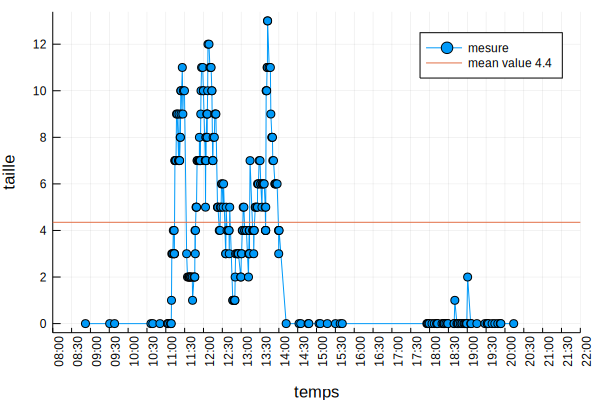

In [247]:
# illustrations...
temps = [x[1] for x in shop.queue]
taille = [x[2] for x in shop.queue]

# make-up
xtimes = floor(now(),Day) + Hour(8) : Minute(30) : floor(now(),Day) + Hour(22)
xtickval = Dates.value.(xtimes)
xticklabel = Dates.format.(xtimes,"HH:MM")
plot(temps,taille,label="mesure",marker=:circle)
plot!(xlabel="temps",ylabel="taille")
xticks!(xtickval,xticklabel)
plot!(xrotation=90, bottom_margin=5mm)
xlims!(Dates.value(xtimes[1]),Dates.value(xtimes[end]))
yticks!(0:2:12)
plot!([xtimes[1],xtimes[end]],[1,1].*mean(taille),label="mean value $(round(mean(taille),digits=1))")

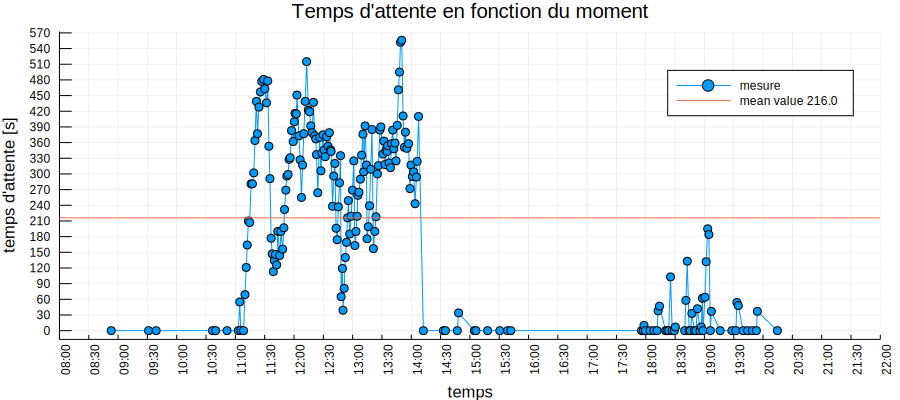

In [245]:
# illustrations...
temps = [x[1] for x in shop.waittime]
taille = [Dates.value(x[2])/1000 for x in shop.waittime] # valeur en secondes
plot(temps,taille,label="mesure",marker=:circle,size=(900,400))
plot!(xlabel="temps",ylabel="temps d'attente [s]",title="Temps d'attente en fonction du moment")

# make-up
xtimes = floor(now(),Day) + Hour(8) : Minute(30) : floor(now(),Day) + Hour(22)
xtickval = Dates.value.(xtimes)
xticklabel = Dates.format.(xtimes,"HH:MM");

xticks!(xtickval,xticklabel)
plot!(xrotation=90, bottom_margin=5mm)
xlims!(Dates.value(xtimes[1]),Dates.value(xtimes[end]))
yticks!(0:30:600)
plot!([xtimes[1],xtimes[end]],[1,1].*mean(taille),label="mean value $(round(mean(taille),digits=1))")

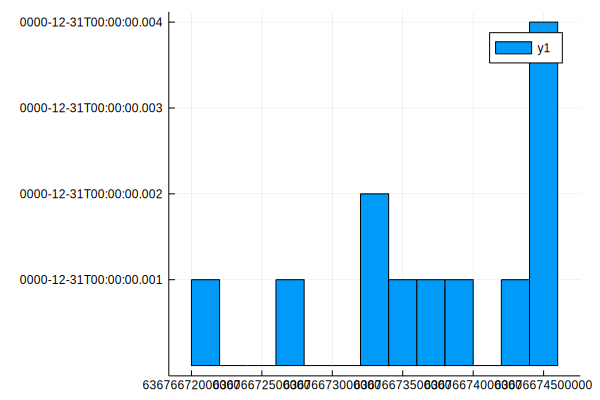

In [235]:
# Histogram laid...
Plots.histogram(shop.renegtimes,nbins=12)

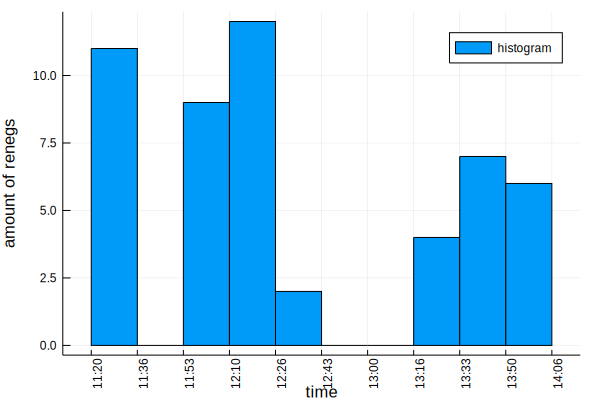

In [246]:
# Petit histogram plus beau
his = StatsBase.fit(Histogram,Dates.value.(shop.renegtimes),nbins=12, closed=:right)
# sortir les limites des paniers de l'histogram
binborders = his.edges[1]
# transformer les limites en quelque chose de lisible
binlabels = Dates.format.(Dates.epochms2datetime.(binborders),"HH:MM")
plot(his,label="histogram",xlabel="time",ylabel="amount of renegs")
xticks!(binborders,binlabels)
plot!(xrotation=90)


### To do:
Run several simulations and store data + do some analysis